In [2]:
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load your dataset (assuming it's in CSV format)
df = pd.read_csv(r"full_job_dataset4.csv", encoding="latin-1")

# Combine the relevant columns into a single text column
df['combined_text'] = df['Sector'] + ' ' + df['Skills'] + ' ' + df['Interests'] + ' ' + df['Description']

# Convert text to lowercase and remove punctuation
df['combined_text'] = df['combined_text'].str.lower().apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove stopwords
stopwords = set(ENGLISH_STOP_WORDS)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

df['combined_text'] = df['combined_text'].apply(remove_stopwords)

# Remove numbers
df['combined_text'] = df['combined_text'].apply(lambda x: re.sub(r'\d+', '', x))

# Tokenize the combined_text column
df['tokenized_text'] = df['combined_text'].apply(lambda x: x.split())

# View the processed text
print(df[['Job Title', 'combined_text']].head())


             Job Title                                      combined_text
0   Software Developer  technology programming java python software de...
1     Registered Nurse  healthcare medicine patient care medical knowl...
2  Mechanical Engineer  engineering cad mechanical design problem solv...
3    Marketing Manager  business marketing branding market research ca...
4         Sports Coach  sports fitness leadership training sports stra...


In [3]:
import numpy as np
from gensim.models import KeyedVectors

# Load Job2Vec model
def load_job2vec_model(job2vec_file_path):
    job2vec_model = KeyedVectors.load(job2vec_file_path, mmap='r')
    return job2vec_model

job2vec_file_path = 'job2vec-master/job2vec.kv'  # Path to your Job2Vec model
job2vec_model = load_job2vec_model(job2vec_file_path)

# Load GloVe model
def load_glove_model(glove_file_path):
    glove_model = {}
    with open(glove_file_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

glove_file_path = 'glove.6B/glove.6B.100d.txt'  # Path to your GloVe model (100d)
glove_model = load_glove_model(glove_file_path)


In [4]:
# Function to get the average Job2Vec vector
def get_average_job2vec_vector(tokens, job2vec_model, vector_size):
    valid_words = [token for token in tokens if token in job2vec_model]
    if len(valid_words) == 0:
        return np.zeros(vector_size)
    return np.mean([job2vec_model[word] for word in valid_words], axis=0)

# Function to get the average GloVe vector
def get_average_glove_vector(tokens, glove_model, vector_size):
    valid_words = [token for token in tokens if token in glove_model]
    if len(valid_words) == 0:
        return np.zeros(vector_size)
    return np.mean([glove_model[word] for word in valid_words], axis=0)

# Merging Job2Vec and GloVe embeddings with a weighted approach
def get_weighted_embedding(tokens, job2vec_model, glove_model, job2vec_weight=0.4, glove_weight=0.6, vector_size=100):
    job2vec_vector = get_average_job2vec_vector(tokens, job2vec_model, vector_size)
    glove_vector = get_average_glove_vector(tokens, glove_model, vector_size)
    
    # Weighted average of both embeddings
    merged_vector = job2vec_weight * job2vec_vector + glove_weight * glove_vector
    return merged_vector

# Apply the weighted embedding function to the tokenized text
df['document_vector'] = df['tokenized_text'].apply(lambda x: get_weighted_embedding(x, job2vec_model, glove_model, vector_size=100))

# View the merged document vectors (Optional)
df[['Job Title', 'document_vector']].head()


,Job Title,document_vector
0,Software Developer,"[-1.0594381, -0.26386732, 1.4162953, 0.0253540..."
1,Registered Nurse,"[-0.102875575, -0.3618337, 0.9195388, 0.197008..."
2,Mechanical Engineer,"[-0.51685005, -0.32922706, 0.81219614, 0.22349..."
3,Marketing Manager,"[-0.5633581, -0.19003208, 0.60222965, 0.060353..."
4,Sports Coach,"[-0.31887215, -0.016841888, 0.4496478, 0.07219..."


In [5]:
from sklearn.cluster import KMeans, DBSCAN

# Convert the 'document_vector' column to a NumPy array for clustering
document_vectors = np.array(df['document_vector'].tolist())

# Apply KMeans clustering for outer clusters
num_clusters = 100 # Adjust this number as needed
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
df['Cluster_Labels'] = kmeans.fit_predict(document_vectors)


C:\Users\uttam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to find the most similar cluster based on input skills/interests
def find_best_cluster(input_text, job2vec_model, glove_model, df):
    input_tokens = input_text.lower().split()
    input_vector = get_weighted_embedding(input_tokens, job2vec_model, glove_model)
    
    # Compute similarity between input vector and each cluster's centroid
    cluster_centroids = df.groupby('Cluster_Labels')['document_vector'].apply(np.mean).tolist()
    similarities = cosine_similarity([input_vector], cluster_centroids)
    
    # Find the best matching cluster
    best_cluster_label = np.argmax(similarities)
    return best_cluster_label

# Function to suggest job titles from the best cluster
def suggest_jobs(input_text, job2vec_model, glove_model, df, top_n=5):
    best_cluster_label = find_best_cluster(input_text, job2vec_model, glove_model, df)
    job_titles_in_best_cluster = df[df['Cluster_Labels'] == best_cluster_label]['Job Title'].unique()
    top_job_titles = job_titles_in_best_cluster[:top_n]
    
    print(f"Top {top_n} Jobs from Cluster {best_cluster_label}:")
    for job in top_job_titles:
        print(f"  - {job}")

# Test the job suggestion system
input_skills = "Education and Academia, Lesson planning, Classroom management, Student assessment"
suggest_jobs(input_skills, job2vec_model, glove_model, df, top_n=5)


Top 5 Jobs from Cluster 45:
  - Educational Consultant
  - Teacher
  - Teacher Assistant
  - School Principal
  - Martial Arts School Administrator


In [7]:
input_skills = "Biochemical analysis, Laboratory research, Data interpretation, Biochemistry, Research, Science"
suggest_jobs(input_skills, job2vec_model, glove_model, df, top_n=5)

Top 5 Jobs from Cluster 51:
  - Data Scientist
  - Business Intelligence Analyst
  - Machine Learning Engineer
  - Data Engineer
  - Digital Twins Engineer


In [8]:
input_skills = "Corporate law, Contract negotiation, Compliance, Law, Corporate governance, Legal advice"
suggest_jobs(input_skills, job2vec_model, glove_model, df, top_n=5)

Top 5 Jobs from Cluster 93:
  - Criminal Defense Attorney
  - Intellectual Property Lawyer
  - Corporate Lawyer
  - Mediator
  - Civil Rights Lawyer


In [9]:
input_skills = "army, Military leadership, Strategic planning, Defense operations, Leadership, Strategy, Defense, Army"
suggest_jobs(input_skills, job2vec_model, glove_model, df, top_n=5)

Top 5 Jobs from Cluster 86:
  - Operations Analyst
  - Harbor Pilot
  - Marine Salvage Operator
  - Army General
  - Lieutenant Colonel


In [10]:
input_skills = "programming, software, software design, problem solving, learning"
suggest_jobs(input_skills, job2vec_model, glove_model, df, top_n=5)

Top 5 Jobs from Cluster 29:
  - Software Developer
  - Software Architect
  - DevOps Engineer
  - Software Engineer
  - Robotics Process Automation Developer


In [11]:
input_skills = "Culinary skills, Menu creation, Team management, Cooking, Creativity, Hospitality"
suggest_jobs(input_skills, job2vec_model, glove_model, df, top_n=5)

Top 5 Jobs from Cluster 36:
  - Hotel Concierge
  - Tour Guide
  - Concierge
  - Customer Service Representative
  - Hotel Front Desk Clerk


In [12]:
input_skills = "Investment strategy, Financial analysis, Risk assessment, Finance, Investments, Strategy"
suggest_jobs(input_skills, job2vec_model, glove_model, df, top_n=5)

Top 5 Jobs from Cluster 99:
  - Investment Banker
  - Financial Analyst
  - Investment Analyst
  - Corporate Financial Strategist
  - Financial Data Visualization Specialist


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to find the document vector of a given job title
def get_job_vector(job_title, df):
    # Check if the job title exists in the DataFrame
    if job_title in df['Job Title'].values:
        return df.loc[df['Job Title'] == job_title, 'document_vector'].values[0]
    else:
        return None

# Function to suggest similar jobs based on the input job title
def suggest_similar_jobs(input_job_title, df, top_n=5):
    job_vector = get_job_vector(input_job_title, df)
    
    if job_vector is None:
        print(f"Job title '{input_job_title}' not found in the dataset.")
        return
    
    # Compute cosine similarity between the input job vector and all job vectors in the DataFrame
    document_vectors = np.array(df['document_vector'].tolist())
    similarities = cosine_similarity([job_vector], document_vectors).flatten()
    
    # Get the indices of the top_n similar jobs (excluding the input job itself)
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]  # Exclude the job itself

    # Use a set to track unique job titles
    unique_jobs = set()
    print(f"Top {top_n-1} unique similar jobs to '{input_job_title}':")
    for index in similar_indices:
        job_title = df.iloc[index]['Job Title']
        if job_title not in unique_jobs:  # Check for uniqueness
            unique_jobs.add(job_title)  # Add to the set of unique jobs
            print(f"  - {job_title} (Similarity: {similarities[index]:.4f}")

# Test the job similarity suggestion system
input_job_title = "Teacher"  # Replace with a job title from your dataset
suggest_similar_jobs(input_job_title, df, top_n=6)


Top 5 unique similar jobs to 'Teacher':
  - High School Teacher (Similarity: 0.9838
  - Educational Consultant (Similarity: 0.9749
  - Teacher Assistant (Similarity: 0.9656
  - School Principal (Similarity: 0.9555


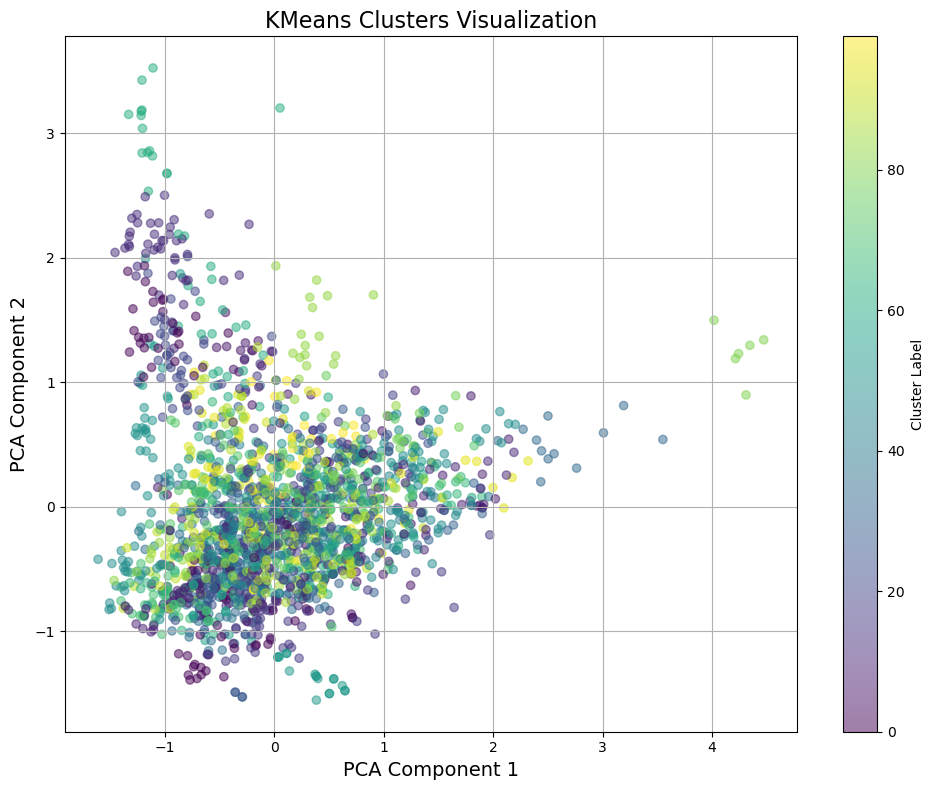

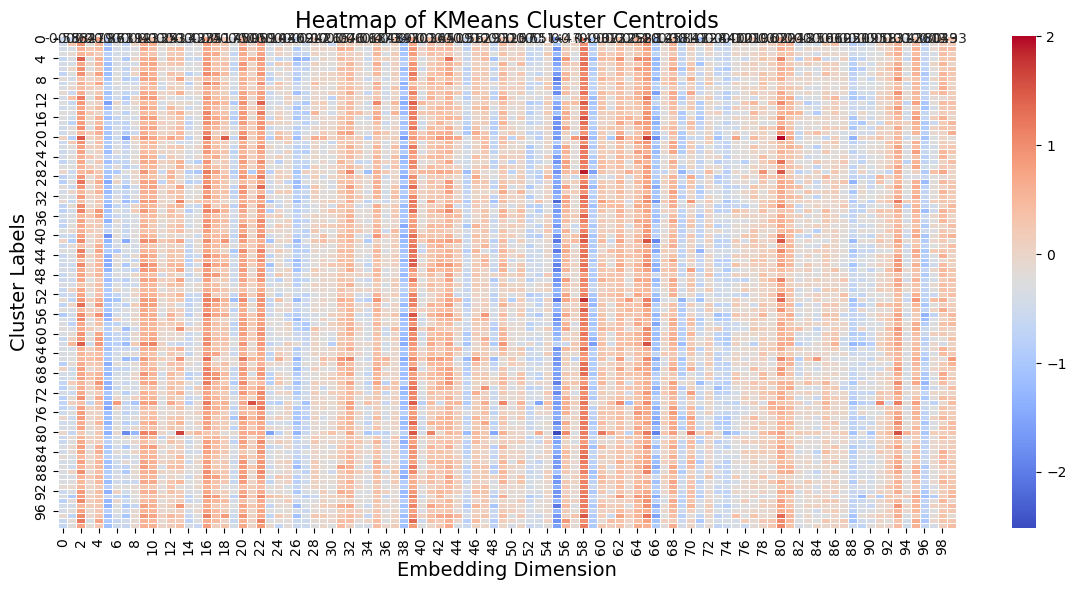

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming 'document_vectors' and 'df' are already defined and contain the necessary data

# Apply PCA to reduce the document vectors to 2D for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(document_vectors)

# Plot KMeans clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], 
                      c=df['Cluster_Labels'], cmap='viridis', alpha=0.5)
plt.title('KMeans Clusters Visualization', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)

# Save the figure
plt.savefig('kmeans_clusters_visualization.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Calculate the centroids of each cluster
centroids = df.groupby('Cluster_Labels')['document_vector'].apply(np.mean).tolist()
centroids = np.array(centroids)

# Create a heatmap of cluster centroids
plt.figure(figsize=(12, 6))
sns.heatmap(centroids, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, linewidths=.5)
plt.title('Heatmap of KMeans Cluster Centroids', fontsize=16)
plt.xlabel('Embedding Dimension', fontsize=14)
plt.ylabel('Cluster Labels', fontsize=14)

# Save the heatmap
plt.savefig('kmeans_cluster_centroids_heatmap.png', bbox_inches='tight')
plt.tight_layout()
plt.show()
